# Encyclopedia of Life (EOL) Dataset Landscape Analysis
## Comprehensive Survey of Available Biodiversity Data Resources

This notebook provides a systematic analysis of the datasets available through the Encyclopedia of Life (EOL) and related biodiversity data portals. Rather than analyzing a single dataset, this work surveys the entire landscape of available biodiversity data to understand:

### Research Objectives
1. **Dataset Discovery**: Catalog all biodiversity datasets available through EOL and partners
2. **Data Currency**: Assess how recently these datasets are updated
3. **Data Scale**: Determine the size and scope of each dataset
4. **Data Quality**: Evaluate available information and metadata quality
5. **Research Applications**: Identify what types of research questions each dataset can support

### Methodology
- **Web scraping** of EOL's open data portal with dynamic page detection
- **API exploration** of available endpoints and access methods
- **Metadata analysis** of dataset characteristics and technical details
- **Comparative analysis** across different data types and sources

This approach demonstrates systematic data discovery and evaluation techniques essential for working with real-world scientific data repositories.

---

In [1]:
# Import necessary libraries for web scraping and data analysis
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import json
import os
from datetime import datetime, timedelta
import re
import time
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print("Libraries imported successfully!")
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Analysis started at: 2025-06-22 22:04:04


## 1. EOL Open Data Portal Exploration

Let's start by exploring what datasets are available through EOL's open data portal.

In [2]:
# Function to safely make web requests
def safe_request(url, timeout=10, max_retries=3):
    """Make a web request with error handling and retries"""
    for attempt in range(max_retries):
        try:
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
            }
            response = requests.get(url, headers=headers, timeout=timeout)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt + 1} failed for {url}: {e}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)  # Exponential backoff
            else:
                print(f"Failed to fetch {url} after {max_retries} attempts")
                return None

# EOL data sources to explore
eol_data_sources = {
    'EOL Open Data Portal': 'https://opendata.eol.org/',
    'EOL API Documentation': 'https://eol.org/docs/what-is-eol/data-services/classic-apis',
    'EOL TraitBank': 'https://eol.org/traitbank',
    'GBIF Portal': 'https://www.gbif.org/dataset/search',
    'TRY Database': 'https://www.try-db.org/TryWeb/Home.php'
}

print("Data sources to explore:")
for name, url in eol_data_sources.items():
    print(f"  • {name}: {url}")

Data sources to explore:
  • EOL Open Data Portal: https://opendata.eol.org/
  • EOL API Documentation: https://eol.org/docs/what-is-eol/data-services/classic-apis
  • EOL TraitBank: https://eol.org/traitbank
  • GBIF Portal: https://www.gbif.org/dataset/search
  • TRY Database: https://www.try-db.org/TryWeb/Home.php


In [3]:
# Let's start by exploring the EOL Open Data Portal structure
eol_portal_url = 'https://opendata.eol.org/'

print("Fetching EOL Open Data Portal...")
response = safe_request(eol_portal_url)

if response:
    soup = BeautifulSoup(response.content, 'html.parser')
    print("✓ Successfully accessed EOL Open Data Portal")
    
    # Try to find dataset listings or links
    # This will depend on the actual structure of the site
    dataset_links = soup.find_all('a', href=True)
    
    print(f"Found {len(dataset_links)} links on the page")
    
    # Filter for dataset-related links
    dataset_keywords = ['dataset', 'data', 'download', 'csv', 'traits', 'species']
    relevant_links = []
    
    for link in dataset_links:
        href = link.get('href', '').lower()
        text = link.get_text().lower()
        
        if any(keyword in href or keyword in text for keyword in dataset_keywords):
            relevant_links.append({
                'text': link.get_text().strip(),
                'href': link.get('href'),
                'full_url': requests.compat.urljoin(eol_portal_url, link.get('href'))
            })
    
    print(f"\nFound {len(relevant_links)} potentially relevant dataset links:")
    for i, link in enumerate(relevant_links[:10], 1):  # Show first 10
        print(f"  {i}. {link['text'][:60]}..." if len(link['text']) > 60 else f"  {i}. {link['text']}")
else:
    print("❌ Could not access EOL Open Data Portal")
    print("We'll proceed with known dataset information instead.")

Fetching EOL Open Data Portal...
✓ Successfully accessed EOL Open Data Portal
Found 27 links on the page

Found 11 potentially relevant dataset links:
  1. Datasets
  2. taxonomic inference
  3. Textmined literature
  4. NMNH
  5. 739
          datasets
  6. EOL Opendata Discussion Forum
  7. EOL Dynamic Hierarchy Data Sets
  8. IOC World Bird List (IOC) - active
  9. EOL Dynamic Hierarchy
  10. EOL computer vision pipelines


## 2. Dynamic EOL Dataset Discovery

This section implements a comprehensive discovery system to catalog all datasets available through the EOL open data portal. The approach dynamically determines the total number of pages and datasets available, ensuring the analysis remains current as the portal content changes.

### Methodology

- **Dynamic Page Detection**: Automatically determines the total number of pages in the portal
- **Robust Error Handling**: Implements retry logic and graceful failure recovery
- **Progress Tracking**: Saves progress periodically to prevent data loss
- **Metadata Extraction**: Captures dataset titles, descriptions, tags, and technical details
- **Respectful Scraping**: Implements appropriate delays between requests

This systematic approach provides a comprehensive view of the entire biodiversity data landscape available through EOL.

In [6]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
from tqdm import tqdm
import re
from urllib.parse import urljoin, urlparse

# Safe request function with enhanced error handling
def safe_request(url, retries=3, delay=1):
    """Make a GET request to the given URL with error handling and retry logic"""
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    for attempt in range(retries):
        try:
            response = requests.get(url, timeout=15, headers=headers)
            response.raise_for_status()  # Raise an error for bad responses (4xx, 5xx)
            return response
        except requests.RequestException as e:
            print(f"Request error for {url} (attempt {attempt + 1}/{retries}): {e}")
            if attempt < retries - 1:
                time.sleep(delay * (attempt + 1))  # Exponential backoff
    return None

def determine_total_pages(base_url="https://opendata.eol.org"):
    """
    Dynamically determine the total number of pages in the EOL dataset portal.
    Returns tuple of (total_pages, total_datasets) or (None, None) if unable to determine.
    """
    url = f"{base_url}/dataset"
    response = safe_request(url)
    
    if not response:
        print("Unable to access the EOL dataset portal to determine total pages")
        return None, None
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Strategy 1: Look for pagination indicators
    pagination_selectors = [
        '.pagination a', '.pager a', '[class*="pagination"] a',
        '.page-links a', '.paging a', '[href*="page="]'
    ]
    
    max_page = 0
    for selector in pagination_selectors:
        page_links = soup.select(selector)
        for link in page_links:
            href = link.get('href', '')
            page_match = re.search(r'page=(\d+)', href)
            if page_match:
                page_num = int(page_match.group(1))
                max_page = max(max_page, page_num)
    
    # Strategy 2: Look for explicit count information
    total_datasets = None
    count_patterns = [
        r'(\d+)\s+datasets?',
        r'(\d+)\s+results?',
        r'showing.*?of\s+(\d+)',
        r'total[:\s]+(\d+)'
    ]
    
    page_text = soup.get_text().lower()
    for pattern in count_patterns:
        count_match = re.search(pattern, page_text)
        if count_match:
            total_datasets = int(count_match.group(1))
            break
    
    # Strategy 3: Check the last page link explicitly
    if max_page == 0:
        # Look for "last", "»", or high page numbers
        all_links = soup.find_all('a', href=True)
        for link in all_links:
            href = link.get('href', '')
            text = link.get_text().strip().lower()
            
            if 'last' in text or '»' in text:
                page_match = re.search(r'page=(\d+)', href)
                if page_match:
                    max_page = int(page_match.group(1))
                    break
    
    if max_page > 0:
        print(f"Detected {max_page} total pages in the EOL dataset portal")
        if total_datasets:
            print(f"Detected approximately {total_datasets} total datasets")
        return max_page, total_datasets
    else:
        print("Unable to automatically determine total pages. Using fallback approach.")
        return None, None

# Enhanced function to scrape dataset information from EOL open data portal
def scrape_eol_dataset_page(page_num, base_url="https://opendata.eol.org"):
    """Scrape a single page of the EOL open data portal with enhanced error handling"""
    url = f"{base_url}/dataset?page={page_num}"
    
    response = safe_request(url)
    if not response:
        return []
    
    soup = BeautifulSoup(response.content, 'html.parser')
    datasets = []
    
    # Multiple strategies to find dataset listings
    dataset_selectors = [
        'li.dataset-item',
        'div.dataset-item', 
        'article.dataset-item',
        '.dataset-item',
        'li.package-item',
        'div.package-item',
        '.package-item',
        'li[class*="dataset"]',
        'div[class*="dataset"]'
    ]
    
    dataset_elements = []
    found_selector = None
    
    # Try each selector until we find dataset elements
    for selector in dataset_selectors:
        elements = soup.select(selector)
        if elements:
            dataset_elements = elements
            found_selector = selector
            break
    
    # Fallback strategies
    if not dataset_elements:
        # Strategy 1: Look for links with 'dataset' in the URL
        all_links = soup.find_all('a', href=True)
        dataset_links = [link for link in all_links if '/dataset/' in link.get('href', '')]
        
        if dataset_links:
            dataset_elements = dataset_links
            found_selector = "dataset links"
        else:
            # Strategy 2: Look for any structured list items that might contain datasets
            list_items = soup.find_all('li')
            if list_items:
                # Filter list items that contain links
                dataset_elements = [li for li in list_items if li.find('a')]
                found_selector = "list items with links"
    
    print(f"Page {page_num}: Found {len(dataset_elements)} elements using '{found_selector}'")
    
    for element in dataset_elements:
        try:
            dataset_info = extract_dataset_info(element, base_url, page_num)
            if dataset_info and dataset_info.get('title'):  # Only add if we found a title
                datasets.append(dataset_info)
        except Exception as e:
            print(f"Error parsing dataset element on page {page_num}: {e}")
            continue
    
    return datasets

def extract_dataset_info(element, base_url, page_num):
    """Extract dataset information from a single element"""
    dataset_info = {'page_found': page_num}
    
    try:
        # Strategy 1: Element is a link itself
        if element.name == 'a':
            title = element.get_text().strip()
            url = element.get('href')
        else:
            # Strategy 2: Find link within the element
            link_element = element.find('a')
            if link_element:
                title = link_element.get_text().strip()
                url = link_element.get('href')
            else:
                # Strategy 3: Look for any text that might be a title
                title_candidates = element.find_all(['h1', 'h2', 'h3', 'h4', 'strong'])
                if title_candidates:
                    title = title_candidates[0].get_text().strip()
                    url = ""
                else:
                    title = element.get_text().strip()[:100]  # Limit length
                    url = ""
        
        # Clean and validate title
        title = re.sub(r'\s+', ' ', title).strip()
        if not title or len(title) < 3:
            return None
        
        dataset_info['title'] = title
        
        # Make URL absolute
        if url:
            if url.startswith('/'):
                url = f"{base_url}{url}"
            elif url.startswith('http'):
                url = url
            else:
                url = f"{base_url}/{url}"
        dataset_info['url'] = url
        
        # Extract description
        description = ""
        # Look for description in various elements
        desc_selectors = ['p', '.notes', '.description', '[class*="desc"]', '.summary']
        for selector in desc_selectors:
            desc_element = element.select_one(selector)
            if desc_element:
                desc_text = desc_element.get_text().strip()
                if len(desc_text) > 20:  # Only use substantial descriptions
                    description = desc_text
                    break
        
        dataset_info['description'] = description[:300] + '...' if len(description) > 300 else description
        
        # Extract tags/categories
        tags = []
        tag_selectors = [
            '[class*="tag"]', '[class*="label"]', '[class*="category"]',
            '.tags span', '.labels span', '.metadata span'
        ]
        for selector in tag_selectors:
            tag_elements = element.select(selector)
            for tag_elem in tag_elements:
                tag_text = tag_elem.get_text().strip()
                if tag_text and len(tag_text) < 50:  # Reasonable tag length
                    tags.append(tag_text)
        
        dataset_info['tags'] = list(set(tags))  # Remove duplicates
        
        # Look for metadata hints (file size, format, etc.)
        metadata = {}
        
        # Look for file format indicators
        text_content = element.get_text().lower()
        formats = ['csv', 'json', 'xml', 'zip', 'xlsx', 'txt', 'rdf', 'ttl']
        found_formats = [fmt for fmt in formats if fmt in text_content]
        if found_formats:
            metadata['formats'] = found_formats
        
        # Look for size indicators
        size_pattern = r'(\d+(?:\.\d+)?)\s*(kb|mb|gb|bytes?)'
        size_match = re.search(size_pattern, text_content, re.IGNORECASE)
        if size_match:
            metadata['size'] = size_match.group(0)
        
        # Look for date patterns
        date_pattern = r'(\d{4}[-/]\d{1,2}[-/]\d{1,2}|\w+ \d{1,2},? \d{4})'
        date_match = re.search(date_pattern, element.get_text())
        if date_match:
            metadata['date_mentioned'] = date_match.group(0)
        
        dataset_info['metadata'] = metadata
        
        return dataset_info
        
    except Exception as e:
        print(f"Error extracting dataset info: {e}")
        return None

# Enhanced function to get detailed information about a specific dataset
def get_dataset_details(dataset_url, timeout=10):
    """Get detailed information about a specific dataset with timeout"""
    if not dataset_url or not dataset_url.startswith('http'):
        return {}
    
    response = safe_request(dataset_url, retries=2)
    if not response:
        return {'error': 'Could not access dataset page'}
    
    soup = BeautifulSoup(response.content, 'html.parser')
    details = {}
    
    try:
        # Enhanced metadata extraction
        # Title
        title_selectors = [
            'h1.dataset-title', 'h1', '.page-header h1', 
            '.dataset-title', 'title', '.package-title'
        ]
        for selector in title_selectors:
            title_elem = soup.select_one(selector)
            if title_elem:
                details['title'] = title_elem.get_text().strip()
                break
        
        # Description  
        desc_selectors = [
            '.notes', '.description', '.dataset-description', 
            '[name="description"]', '.package-notes', '.summary'
        ]
        for selector in desc_selectors:
            desc_elem = soup.select_one(selector)
            if desc_elem:
                if desc_elem.name == 'meta':
                    details['description'] = desc_elem.get('content', '')
                else:
                    details['description'] = desc_elem.get_text().strip()
                break
        
        # Download links and file information
        download_links = []
        for link in soup.find_all('a', href=True):
            href = link.get('href', '').lower()
            link_text = link.get_text().strip().lower()
            
            # Look for download-related patterns
            if any(pattern in href or pattern in link_text for pattern in 
                   ['.csv', '.json', '.xml', '.zip', '.txt', '.xlsx', 'download', 'export']):
                download_links.append({
                    'text': link.get_text().strip(),
                    'url': urljoin(dataset_url, link.get('href')),
                    'type': href.split('.')[-1] if '.' in href else 'unknown'
                })
        
        details['download_links'] = download_links
        
        # Enhanced metadata extraction from tables and structured data
        metadata = {}
        
        # Look for metadata in tables
        for table in soup.find_all('table'):
            for row in table.find_all('tr'):
                cells = row.find_all(['td', 'th'])
                if len(cells) == 2:
                    key = cells[0].get_text().strip().lower()
                    value = cells[1].get_text().strip()
                    if key and value:
                        metadata[key] = value
        
        # Look for metadata in definition lists
        for dl in soup.find_all('dl'):
            terms = dl.find_all('dt')
            definitions = dl.find_all('dd')
            for term, definition in zip(terms, definitions):
                key = term.get_text().strip().lower()
                value = definition.get_text().strip()
                if key and value:
                    metadata[key] = value
        
        # Look for specific metadata patterns
        text_content = soup.get_text()
        
        # File size
        size_pattern = r'size[:\s]*(\d+(?:\.\d+)?)\s*(kb|mb|gb|bytes?)'
        size_match = re.search(size_pattern, text_content, re.IGNORECASE)
        if size_match:
            metadata['file_size'] = size_match.group(1) + ' ' + size_match.group(2)
        
        # Last updated
        update_patterns = [
            r'updated[:\s]*(\d{4}[-/]\d{1,2}[-/]\d{1,2})',
            r'last modified[:\s]*(\d{4}[-/]\d{1,2}[-/]\d{1,2})',
            r'(\d{4}[-/]\d{1,2}[-/]\d{1,2})'
        ]
        for pattern in update_patterns:
            update_match = re.search(pattern, text_content, re.IGNORECASE)
            if update_match:
                metadata['last_updated'] = update_match.group(1)
                break
        
        if metadata:
            details['metadata'] = metadata
        
        # Extract tags/keywords
        tags = []
        tag_selectors = [
            '.tags a', '.keywords a', '[class*="tag"]', 
            '.labels span', '.categories a'
        ]
        for selector in tag_selectors:
            for tag_elem in soup.select(selector):
                tag_text = tag_elem.get_text().strip()
                if tag_text and len(tag_text) < 50:
                    tags.append(tag_text)
        
        details['tags'] = list(set(tags))
        
    except Exception as e:
        details['error'] = f"Error extracting details: {e}"
    
    return details

print("DYNAMIC EOL DATASET DISCOVERY - Core Functions Loaded")
print("=" * 60)

# Determine the total scope dynamically
print("Analyzing EOL dataset portal structure...")
total_pages, total_datasets = determine_total_pages()

if total_pages:
    print(f"Portal analysis complete. Ready to process {total_pages} pages.")
    if total_datasets:
        print(f"Expected to discover approximately {total_datasets} datasets.")
else:
    print("Using fallback approach: will determine pages dynamically during scraping.")

print()
print("Testing approach with first few pages...")

# Test with first few pages to validate approach
test_pages = 3
test_datasets = []
for page_num in range(1, test_pages + 1):
    try:
        page_datasets = scrape_eol_dataset_page(page_num)
        test_datasets.extend(page_datasets)
        print(f"Page {page_num}: Found {len(page_datasets)} datasets")
        time.sleep(1)  # Be respectful
    except Exception as e:
        print(f"Error on page {page_num}: {e}")

print(f"\nTest Results:")
print(f"Total datasets found in {test_pages} pages: {len(test_datasets)}")

if test_datasets:
    print(f"\nSample discovered datasets:")
    for i, dataset in enumerate(test_datasets[:3], 1):
        print(f"\n{i}. {dataset['title']}")
        if dataset.get('description'):
            print(f"   Description: {dataset['description'][:100]}...")
        if dataset.get('url'):
            print(f"   URL: {dataset['url']}")
        if dataset.get('tags'):
            print(f"   Tags: {', '.join(dataset['tags'][:3])}")
        if dataset.get('metadata'):
            print(f"   Metadata: {dataset['metadata']}")
    
    print(f"\nValidation successful. Ready for full discovery.")
    
else:
    print("Validation failed - analyzing page structure for debugging...")
    
    # Analyze page structure for debugging
    response = safe_request("https://opendata.eol.org/dataset")
    if response:
        soup = BeautifulSoup(response.content, 'html.parser')
        print(f"\nPage Structure Analysis:")
        print(f"Page title: {soup.title.get_text() if soup.title else 'No title'}")
        print(f"Total links found: {len(soup.find_all('a'))}")
        print(f"Total list items: {len(soup.find_all('li'))}")
        print(f"Total divs: {len(soup.find_all('div'))}")
        
        # Show sample links
        print(f"\nSample links (first 5):")
        for i, link in enumerate(soup.find_all('a', href=True)[:5], 1):
            print(f"  {i}. Text: '{link.get_text().strip()[:50]}'")
            print(f"     Href: '{link.get('href')}'")
            print(f"     Classes: {link.get('class', [])}")
            print()

DYNAMIC EOL DATASET DISCOVERY - Core Functions Loaded
Analyzing EOL dataset portal structure...
Detected 37 total pages in the EOL dataset portal
Detected approximately 739 total datasets
Portal analysis complete. Ready to process 37 pages.
Expected to discover approximately 739 datasets.

Testing approach with first few pages...
Detected 37 total pages in the EOL dataset portal
Detected approximately 739 total datasets
Portal analysis complete. Ready to process 37 pages.
Expected to discover approximately 739 datasets.

Testing approach with first few pages...
Page 1: Found 20 elements using 'li.dataset-item'
Page 1: Found 20 datasets
Page 1: Found 20 elements using 'li.dataset-item'
Page 1: Found 20 datasets
Page 2: Found 20 elements using 'li.dataset-item'
Page 2: Found 20 datasets
Page 2: Found 20 elements using 'li.dataset-item'
Page 2: Found 20 datasets
Page 3: Found 20 elements using 'li.dataset-item'
Page 3: Found 20 datasets
Page 3: Found 20 elements using 'li.dataset-item'
Pa

In [8]:
# Import additional required modules
import os
import json
from datetime import datetime

# Dynamic EOL dataset discovery function
def discover_all_eol_datasets(max_pages=None, start_page=1, save_progress=True):
    """
    Discover and catalog all datasets from the EOL open data portal
    
    Parameters:
    - max_pages: Maximum number of pages to scrape (None for auto-detection)
    - start_page: Starting page number (default: 1)
    - save_progress: Save progress periodically (default: True)
    
    Returns:
    - List of all discovered datasets with metadata
    """
    print(f"EOL DATASET DISCOVERY")
    print(f"=" * 50)
    
    # Auto-detect total pages if not provided
    if max_pages is None:
        detected_pages, detected_datasets = determine_total_pages()
        if detected_pages:
            max_pages = detected_pages
            print(f"Auto-detected {max_pages} pages to process")
            if detected_datasets:
                print(f"Expected to find approximately {detected_datasets} datasets")
        else:
            # Fallback: try pages until we find empty pages
            print("Auto-detection failed. Using dynamic discovery approach.")
            max_pages = discover_total_pages_dynamically()
    
    # Ensure max_pages is at least the start_page
    max_pages = max(max_pages, start_page)
    
    print(f"Processing pages {start_page} to {max_pages}")
    estimated_time = (max_pages - start_page + 1) * 2 / 60
    print(f"Estimated processing time: {estimated_time:.1f} minutes")
    print()
    
    all_datasets = []
    errors = []
    progress_file = '../data/processed/eol_discovery_progress.json'
    
    # Create progress directory
    os.makedirs(os.path.dirname(progress_file), exist_ok=True)
    
    # Progress tracking with tqdm
    with tqdm(range(start_page, max_pages + 1), desc="Processing pages") as pbar:
        for page_num in pbar:
            try:
                pbar.set_description(f"Processing page {page_num}")
                
                # Scrape the page
                page_datasets = scrape_eol_dataset_page(page_num)
                
                # If no datasets found on this page and we're beyond page 5, 
                # assume we've reached the end
                if not page_datasets and page_num > 5:
                    print(f"\nNo datasets found on page {page_num}. Assuming end of data.")
                    break
                
                all_datasets.extend(page_datasets)
                
                # Update progress bar
                pbar.set_postfix({
                    'datasets': len(all_datasets),
                    'this_page': len(page_datasets),
                    'errors': len(errors)
                })
                
                # Save progress every 5 pages
                if save_progress and page_num % 5 == 0:
                    progress_data = {
                        'last_page': page_num,
                        'datasets_found': len(all_datasets),
                        'datasets': all_datasets,
                        'errors': errors,
                        'timestamp': datetime.now().isoformat()
                    }
                    with open(progress_file, 'w') as f:
                        json.dump(progress_data, f, indent=2)
                
                # Respectful delay
                time.sleep(1.5)
                
            except Exception as e:
                error_msg = f"Error scraping page {page_num}: {e}"
                errors.append(error_msg)
                pbar.set_postfix({
                    'datasets': len(all_datasets),
                    'errors': len(errors)
                })
                print(f"\n{error_msg}")
                time.sleep(2)  # Longer delay after error
    
    print(f"\nDISCOVERY COMPLETE")
    print(f"Final Results:")
    print(f"   Total datasets discovered: {len(all_datasets)}")
    print(f"   Pages processed: {page_num - start_page + 1}")
    print(f"   Errors encountered: {len(errors)}")
    success_rate = (1 - len(errors)/(page_num - start_page + 1))*100 if page_num > start_page else 100
    print(f"   Success rate: {success_rate:.1f}%")
    
    return all_datasets, errors

def discover_total_pages_dynamically():
    """
    Dynamically discover the total number of pages by checking when pages become empty.
    This is a fallback method when auto-detection fails.
    """
    print("Discovering total pages dynamically...")
    test_page = 1
    empty_pages = 0
    
    while empty_pages < 3:  # Stop after 3 consecutive empty pages
        datasets = scrape_eol_dataset_page(test_page)
        if not datasets:
            empty_pages += 1
        else:
            empty_pages = 0
        test_page += 1
        
        # Safety limit
        if test_page > 100:
            print("Reached safety limit of 100 pages")
            break
    
    total_pages = test_page - empty_pages - 1
    print(f"Dynamically determined {total_pages} total pages")
    return total_pages

# Enhanced analysis function for discovered datasets
def analyze_discovered_datasets(datasets):
    """Analyze the discovered datasets to extract insights"""
    if not datasets:
        print("No datasets to analyze")
        return
    
    df = pd.DataFrame(datasets)
    
    print(f"\nDATASET ANALYSIS")
    print(f"=" * 40)
    
    # Basic statistics
    print(f"Basic Statistics:")
    print(f"   Total datasets: {len(df)}")
    print(f"   Datasets with URLs: {df['url'].notna().sum()}")
    print(f"   Datasets with descriptions: {df['description'].notna().sum()}")
    print(f"   Average title length: {df['title'].str.len().mean():.1f} characters")
    
    # Page distribution
    print(f"\nPage Distribution:")
    page_counts = df['page_found'].value_counts().sort_index()
    print(f"   Datasets per page range: {page_counts.min()} - {page_counts.max()}")
    print(f"   Average datasets per page: {page_counts.mean():.1f}")
    
    # Tags analysis
    all_tags = []
    for tags in df['tags']:
        if isinstance(tags, list):
            all_tags.extend(tags)
    
    if all_tags:
        tag_counts = pd.Series(all_tags).value_counts()
        print(f"\nTag Analysis:")
        print(f"   Total unique tags: {len(tag_counts)}")
        print(f"   Most common tags: {', '.join(tag_counts.head(5).index.tolist())}")
    
    # Metadata analysis
    metadata_fields = []
    for metadata in df['metadata']:
        if isinstance(metadata, dict):
            metadata_fields.extend(metadata.keys())
    
    if metadata_fields:
        field_counts = pd.Series(metadata_fields).value_counts()
        print(f"\nMetadata Fields:")
        print(f"   Common metadata fields: {', '.join(field_counts.head(3).index.tolist())}")
    
    # URL analysis
    domains = []
    for url in df['url'].dropna():
        try:
            domain = urlparse(url).netloc
            domains.append(domain)
        except:
            pass
    
    if domains:
        domain_counts = pd.Series(domains).value_counts()
        print(f"\nURL Domains:")
        print(f"   Primary domain: {domain_counts.index[0]} ({domain_counts.iloc[0]} datasets)")
    
    return df

# Export function for discovered datasets
def export_dataset_catalog(datasets, export_path=None):
    """Export the discovered datasets to various formats"""
    if not export_path:
        export_path = '../data/processed/eol_complete_dataset_catalog'
    
    # Create directory
    os.makedirs(os.path.dirname(export_path + '.json'), exist_ok=True)
    
    # Create comprehensive catalog
    catalog = {
        'metadata': {
            'discovery_date': datetime.now().isoformat(),
            'total_datasets': len(datasets),
            'source': 'EOL Open Data Portal (opendata.eol.org)',
            'discovery_method': 'Automated web scraping',
            'pages_scraped': len(set(d.get('page_found', 0) for d in datasets)),
        },
        'summary_statistics': {
            'datasets_with_urls': sum(1 for d in datasets if d.get('url')),
            'datasets_with_descriptions': sum(1 for d in datasets if d.get('description')),
            'datasets_with_tags': sum(1 for d in datasets if d.get('tags')),
            'datasets_with_metadata': sum(1 for d in datasets if d.get('metadata')),
        },
        'datasets': datasets
    }
    
    # Export as JSON
    with open(f"{export_path}.json", 'w', encoding='utf-8') as f:
        json.dump(catalog, f, indent=2, ensure_ascii=False)
    
    # Export as CSV
    df = pd.DataFrame(datasets)
    
    # Flatten complex fields for CSV
    df_export = df.copy()
    df_export['tags_str'] = df_export['tags'].apply(lambda x: '; '.join(x) if isinstance(x, list) else '')
    df_export['metadata_str'] = df_export['metadata'].apply(lambda x: str(x) if isinstance(x, dict) else '')
    
    # Select columns for CSV
    csv_columns = ['title', 'url', 'description', 'tags_str', 'metadata_str', 'page_found']
    df_export[csv_columns].to_csv(f"{export_path}.csv", index=False, encoding='utf-8')
    
    # Export summary report
    with open(f"{export_path}_summary.txt", 'w', encoding='utf-8') as f:
        f.write("EOL DATASET DISCOVERY SUMMARY\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Discovery Date: {catalog['metadata']['discovery_date']}\n")
        f.write(f"Total Datasets: {catalog['metadata']['total_datasets']}\n")
        f.write(f"Pages Scraped: {catalog['metadata']['pages_scraped']}\n")
        f.write(f"Source: {catalog['metadata']['source']}\n\n")
        
        f.write("STATISTICS:\n")
        f.write("-" * 20 + "\n")
        for key, value in catalog['summary_statistics'].items():
            f.write(f"{key.replace('_', ' ').title()}: {value}\n")
        
        # Top datasets by title length (proxy for detail)
        df_sorted = pd.DataFrame(datasets).sort_values('title', key=lambda x: x.str.len(), ascending=False)
        f.write(f"\nSAMPLE DATASETS (Top 10 by title detail):\n")
        f.write("-" * 40 + "\n")
        for i, row in df_sorted.head(10).iterrows():
            f.write(f"{i+1:2d}. {row['title']}\n")
            if row.get('description'):
                f.write(f"    Description: {row['description'][:100]}...\n")
            if row.get('url'):
                f.write(f"    URL: {row['url']}\n")
            f.write("\n")
    
    print(f"\nEXPORT COMPLETE:")
    print(f"   JSON catalog: {export_path}.json")
    print(f"   CSV file: {export_path}.csv") 
    print(f"   Summary report: {export_path}_summary.txt")
    
    return export_path

print("Enhanced discovery functions loaded.")
print("Ready to discover all EOL datasets dynamically.")
print("\nNext steps:")
print("1. Run: all_datasets, errors = discover_all_eol_datasets()")
print("2. Analyze: analyze_discovered_datasets(all_datasets)")
print("3. Export: export_dataset_catalog(all_datasets)")

Enhanced discovery functions loaded.
Ready to discover all EOL datasets dynamically.

Next steps:
1. Run: all_datasets, errors = discover_all_eol_datasets()
2. Analyze: analyze_discovered_datasets(all_datasets)
3. Export: export_dataset_catalog(all_datasets)


In [9]:
# Execute the dynamic discovery of all EOL datasets
print("STARTING DYNAMIC EOL DATASET DISCOVERY")
print("This process will automatically determine the total number of pages and datasets.")
print("Progress will be saved every 5 pages for safety.")
print()

# Run the comprehensive discovery with dynamic page detection
all_datasets, errors = discover_all_eol_datasets(max_pages=None, start_page=1, save_progress=True)

print(f"\nDISCOVERY COMPLETED")
print(f"Found {len(all_datasets)} total datasets")

if errors:
    print(f"Warning: {len(errors)} errors occurred:")
    for error in errors[:5]:  # Show first 5 errors
        print(f"   {error}")
    if len(errors) > 5:
        print(f"   ... and {len(errors) - 5} more errors")
else:
    print("Success: No errors encountered during discovery")

# Summary of results
if all_datasets:
    print(f"\nDataset Discovery Summary:")
    print(f"   First dataset: {all_datasets[0]['title']}")
    print(f"   Last dataset: {all_datasets[-1]['title']}")
    print(f"   Datasets with URLs: {sum(1 for d in all_datasets if d.get('url'))}")
    print(f"   Datasets with descriptions: {sum(1 for d in all_datasets if d.get('description'))}")
    print(f"   Datasets with tags: {sum(1 for d in all_datasets if d.get('tags'))}")
    
    # Show sample datasets with rich descriptions
    datasets_with_description = [d for d in all_datasets if d.get('description') and len(d['description']) > 50]
    if datasets_with_description:
        print(f"\nSample datasets with detailed descriptions:")
        for i, dataset in enumerate(datasets_with_description[:3], 1):
            print(f"\n   {i}. {dataset['title']}")
            print(f"      Description: {dataset['description'][:150]}...")
            if dataset.get('tags'):
                print(f"      Tags: {', '.join(dataset['tags'][:5])}")

STARTING DYNAMIC EOL DATASET DISCOVERY
This process will automatically determine the total number of pages and datasets.
Progress will be saved every 5 pages for safety.

EOL DATASET DISCOVERY
Detected 37 total pages in the EOL dataset portal
Detected approximately 739 total datasets
Auto-detected 37 pages to process
Expected to find approximately 739 datasets
Processing pages 1 to 37
Estimated processing time: 1.2 minutes

Detected 37 total pages in the EOL dataset portal
Detected approximately 739 total datasets
Auto-detected 37 pages to process
Expected to find approximately 739 datasets
Processing pages 1 to 37
Estimated processing time: 1.2 minutes



Processing page 1:   0%|          | 0/37 [00:00<?, ?it/s, datasets=20, this_page=20, errors=0]

Page 1: Found 20 elements using 'li.dataset-item'


Processing page 2:   3%|▎         | 1/37 [00:02<01:03,  1.76s/it, datasets=40, this_page=20, errors=0]

Page 2: Found 20 elements using 'li.dataset-item'


Processing page 3:   5%|▌         | 2/37 [00:03<01:01,  1.77s/it, datasets=60, this_page=20, errors=0]

Page 3: Found 20 elements using 'li.dataset-item'


Processing page 4:   8%|▊         | 3/37 [00:05<00:59,  1.76s/it, datasets=80, this_page=20, errors=0]

Page 4: Found 20 elements using 'li.dataset-item'


Processing page 5:  11%|█         | 4/37 [00:07<00:58,  1.76s/it, datasets=100, this_page=20, errors=0]

Page 5: Found 20 elements using 'li.dataset-item'


Processing page 6:  14%|█▎        | 5/37 [00:09<00:56,  1.75s/it, datasets=120, this_page=20, errors=0]

Page 6: Found 20 elements using 'li.dataset-item'


Processing page 7:  16%|█▌        | 6/37 [00:10<00:54,  1.75s/it, datasets=140, this_page=20, errors=0]

Page 7: Found 20 elements using 'li.dataset-item'


Processing page 8:  19%|█▉        | 7/37 [00:12<00:52,  1.76s/it, datasets=160, this_page=20, errors=0]

Page 8: Found 20 elements using 'li.dataset-item'


Processing page 9:  22%|██▏       | 8/37 [00:14<00:50,  1.75s/it, datasets=180, this_page=20, errors=0]

Page 9: Found 20 elements using 'li.dataset-item'


Processing page 10:  24%|██▍       | 9/37 [00:16<00:49,  1.75s/it, datasets=200, this_page=20, errors=0]

Page 10: Found 20 elements using 'li.dataset-item'


Processing page 11:  27%|██▋       | 10/37 [00:17<00:47,  1.76s/it, datasets=220, this_page=20, errors=0]

Page 11: Found 20 elements using 'li.dataset-item'


Processing page 12:  30%|██▉       | 11/37 [00:19<00:45,  1.76s/it, datasets=240, this_page=20, errors=0]

Page 12: Found 20 elements using 'li.dataset-item'


Processing page 13:  32%|███▏      | 12/37 [00:21<00:43,  1.76s/it, datasets=260, this_page=20, errors=0]

Page 13: Found 20 elements using 'li.dataset-item'


Processing page 14:  35%|███▌      | 13/37 [00:23<00:42,  1.76s/it, datasets=280, this_page=20, errors=0]

Page 14: Found 20 elements using 'li.dataset-item'


Processing page 15:  38%|███▊      | 14/37 [00:25<00:40,  1.77s/it, datasets=300, this_page=20, errors=0]

Page 15: Found 20 elements using 'li.dataset-item'


Processing page 16:  41%|████      | 15/37 [00:26<00:40,  1.83s/it, datasets=320, this_page=20, errors=0]

Page 16: Found 20 elements using 'li.dataset-item'


Processing page 17:  43%|████▎     | 16/37 [00:28<00:38,  1.82s/it, datasets=340, this_page=20, errors=0]

Page 17: Found 20 elements using 'li.dataset-item'


Processing page 18:  46%|████▌     | 17/37 [00:30<00:36,  1.81s/it, datasets=360, this_page=20, errors=0]

Page 18: Found 20 elements using 'li.dataset-item'


Processing page 19:  49%|████▊     | 18/37 [00:32<00:34,  1.80s/it, datasets=380, this_page=20, errors=0]

Page 19: Found 20 elements using 'li.dataset-item'


Processing page 20:  51%|█████▏    | 19/37 [00:34<00:32,  1.78s/it, datasets=400, this_page=20, errors=0]

Page 20: Found 20 elements using 'li.dataset-item'


Processing page 21:  54%|█████▍    | 20/37 [00:36<00:35,  2.08s/it, datasets=420, this_page=20, errors=0]

Page 21: Found 20 elements using 'li.dataset-item'


Processing page 22:  57%|█████▋    | 21/37 [00:38<00:31,  1.99s/it, datasets=440, this_page=20, errors=0]

Page 22: Found 20 elements using 'li.dataset-item'


Processing page 23:  59%|█████▉    | 22/37 [00:40<00:28,  1.92s/it, datasets=460, this_page=20, errors=0]

Page 23: Found 20 elements using 'li.dataset-item'


Processing page 24:  62%|██████▏   | 23/37 [00:42<00:26,  1.88s/it, datasets=480, this_page=20, errors=0]

Page 24: Found 20 elements using 'li.dataset-item'


Processing page 25:  65%|██████▍   | 24/37 [00:43<00:24,  1.86s/it, datasets=500, this_page=20, errors=0]

Page 25: Found 20 elements using 'li.dataset-item'


Processing page 26:  68%|██████▊   | 25/37 [00:45<00:22,  1.85s/it, datasets=520, this_page=20, errors=0]

Page 26: Found 20 elements using 'li.dataset-item'


Processing page 27:  70%|███████   | 26/37 [00:47<00:19,  1.82s/it, datasets=540, this_page=20, errors=0]

Page 27: Found 20 elements using 'li.dataset-item'


Processing page 28:  73%|███████▎  | 27/37 [00:49<00:18,  1.84s/it, datasets=560, this_page=20, errors=0]

Page 28: Found 20 elements using 'li.dataset-item'


Processing page 29:  76%|███████▌  | 28/37 [00:51<00:16,  1.83s/it, datasets=580, this_page=20, errors=0]

Page 29: Found 20 elements using 'li.dataset-item'


Processing page 30:  78%|███████▊  | 29/37 [00:53<00:14,  1.84s/it, datasets=600, this_page=20, errors=0]

Page 30: Found 20 elements using 'li.dataset-item'


Processing page 31:  81%|████████  | 30/37 [00:54<00:12,  1.83s/it, datasets=620, this_page=20, errors=0]

Page 31: Found 20 elements using 'li.dataset-item'


Processing page 32:  84%|████████▍ | 31/37 [00:56<00:10,  1.81s/it, datasets=640, this_page=20, errors=0]

Page 32: Found 20 elements using 'li.dataset-item'


Processing page 33:  86%|████████▋ | 32/37 [00:58<00:08,  1.80s/it, datasets=660, this_page=20, errors=0]

Page 33: Found 20 elements using 'li.dataset-item'


Processing page 34:  89%|████████▉ | 33/37 [01:00<00:07,  1.78s/it, datasets=680, this_page=20, errors=0]

Page 34: Found 20 elements using 'li.dataset-item'


Processing page 35:  92%|█████████▏| 34/37 [01:01<00:05,  1.77s/it, datasets=700, this_page=20, errors=0]

Page 35: Found 20 elements using 'li.dataset-item'


Processing page 36:  95%|█████████▍| 35/37 [01:03<00:03,  1.77s/it, datasets=720, this_page=20, errors=0]

Page 36: Found 20 elements using 'li.dataset-item'


Processing page 37:  97%|█████████▋| 36/37 [01:05<00:01,  1.77s/it, datasets=739, this_page=19, errors=0]

Page 37: Found 19 elements using 'li.dataset-item'


Processing page 37: 100%|██████████| 37/37 [01:06<00:00,  1.81s/it, datasets=739, this_page=19, errors=0]


DISCOVERY COMPLETE
Final Results:
   Total datasets discovered: 739
   Pages processed: 37
   Errors encountered: 0
   Success rate: 100.0%

DISCOVERY COMPLETED
Found 739 total datasets
Success: No errors encountered during discovery

Dataset Discovery Summary:
   First dataset: Wikimedia
   Last dataset: Afrotropical birds in the RMCA LifeDesk
   Datasets with URLs: 739
   Datasets with descriptions: 219
   Datasets with tags: 715


In [10]:
# Analyze the discovered datasets
print("\n" + "="*60)
print("COMPREHENSIVE ANALYSIS OF DISCOVERED EOL DATASETS")
print("="*60)

# Run the analysis
dataset_analysis_df = analyze_discovered_datasets(all_datasets)

# Export the complete catalog
print("\n" + "="*60)
print("EXPORTING COMPLETE DATASET CATALOG")
print("="*60)

export_path = export_dataset_catalog(all_datasets)

print(f"\nDISCOVERY AND ANALYSIS COMPLETE")
print(f"Successfully discovered and cataloged {len(all_datasets)} EOL datasets")
print(f"Comprehensive dataset catalog exported in multiple formats")
print(f"Data ready for research and analysis applications")

# Show key insights
print(f"\nKEY INSIGHTS:")

# Datasets with rich descriptions
rich_descriptions = [d for d in all_datasets if d.get('description') and len(d['description']) > 100]
print(f"   {len(rich_descriptions)} datasets have detailed descriptions")

# Tag analysis
all_tags_flat = []
for dataset in all_datasets:
    if dataset.get('tags'):
        all_tags_flat.extend(dataset['tags'])

if all_tags_flat:
    tag_series = pd.Series(all_tags_flat).value_counts()
    print(f"   Most common format tags: {', '.join(tag_series.head(5).index.tolist())}")

# Show some sample high-quality datasets
quality_datasets = [d for d in all_datasets 
                   if d.get('description') and len(d['description']) > 50 
                   and d.get('tags') and len(d['tags']) > 0]

print(f"   {len(quality_datasets)} datasets have both descriptions and format tags")

if quality_datasets:
    print(f"\nSample High-Quality Datasets for Research:")
    for i, dataset in enumerate(quality_datasets[:5], 1):
        print(f"\n   {i}. {dataset['title']}")
        print(f"      Description: {dataset['description'][:120]}...")
        print(f"      Tags: {', '.join(dataset['tags'][:5])}")
        print(f"      URL: {dataset['url']}")

print(f"\nThis comprehensive catalog represents the complete landscape")
print(f"of biodiversity data available through the Encyclopedia of Life.")
print(f"\nApplications:")
print(f"   Research planning and dataset selection")
print(f"   Understanding the full scope of available biodiversity data")
print(f"   Comparative analysis of dataset characteristics")
print(f"   Data discovery for scientific analysis")


COMPREHENSIVE ANALYSIS OF DISCOVERED EOL DATASETS

DATASET ANALYSIS
Basic Statistics:
   Total datasets: 739
   Datasets with URLs: 739
   Datasets with descriptions: 739
   Average title length: 22.9 characters

Page Distribution:
   Datasets per page range: 19 - 20
   Average datasets per page: 20.0

Tag Analysis:
   Total unique tags: 16
   Most common tags: ZIP, TAR, XML, XLSX, tar.gz

Metadata Fields:
   Common metadata fields: formats, date_mentioned, size

URL Domains:
   Primary domain: opendata.eol.org (739 datasets)

EXPORTING COMPLETE DATASET CATALOG

EXPORT COMPLETE:
   JSON catalog: ../data/processed/eol_complete_dataset_catalog.json
   CSV file: ../data/processed/eol_complete_dataset_catalog.csv
   Summary report: ../data/processed/eol_complete_dataset_catalog_summary.txt

DISCOVERY AND ANALYSIS COMPLETE
Successfully discovered and cataloged 739 EOL datasets
Comprehensive dataset catalog exported in multiple formats
Data ready for research and analysis applications

KEY 

## 3. Dataset Characteristics Analysis

Let's analyze the characteristics of these datasets to understand the biodiversity data landscape.

In [5]:
# Convert dataset information to DataFrame for analysis
dataset_df = pd.DataFrame.from_dict(biodiversity_datasets, orient='index')
dataset_df['dataset_name'] = dataset_df.index

print("Dataset characteristics summary:")
print(f"Total datasets analyzed: {len(dataset_df)}")
print(f"Primary sources: {dataset_df['primary_source'].nunique()}")
print(f"Update frequencies: {', '.join(dataset_df['update_frequency'].unique())}")

# Display the structured data
display_cols = ['dataset_name', 'estimated_species', 'update_frequency', 'primary_source']
print("\nDataset comparison:")
print(dataset_df[display_cols].to_string(index=False))

Dataset characteristics summary:
Total datasets analyzed: 8
Primary sources: 7
Update frequencies: Continuous (data aggregation), Annual releases, Monthly, Regular updates, Daily, Real-time, Periodic releases

Dataset comparison:
             dataset_name        estimated_species              update_frequency       primary_source
            EOL TraitBank     1.9+ million species Continuous (data aggregation)                  EOL
 TRY Plant Trait Database   279,000+ plant species               Annual releases Max Planck Institute
                 FishBase     34,000+ fish species                       Monthly  FishBase Consortium
              SeaLifeBase   85,000+ marine species                       Monthly  FishBase Consortium
              AmphibiaWeb 8,500+ amphibian species               Regular updates          UC Berkeley
     GBIF Occurrence Data     1.8+ million species                         Daily                 GBIF
iNaturalist Research Data         500,000+ species      

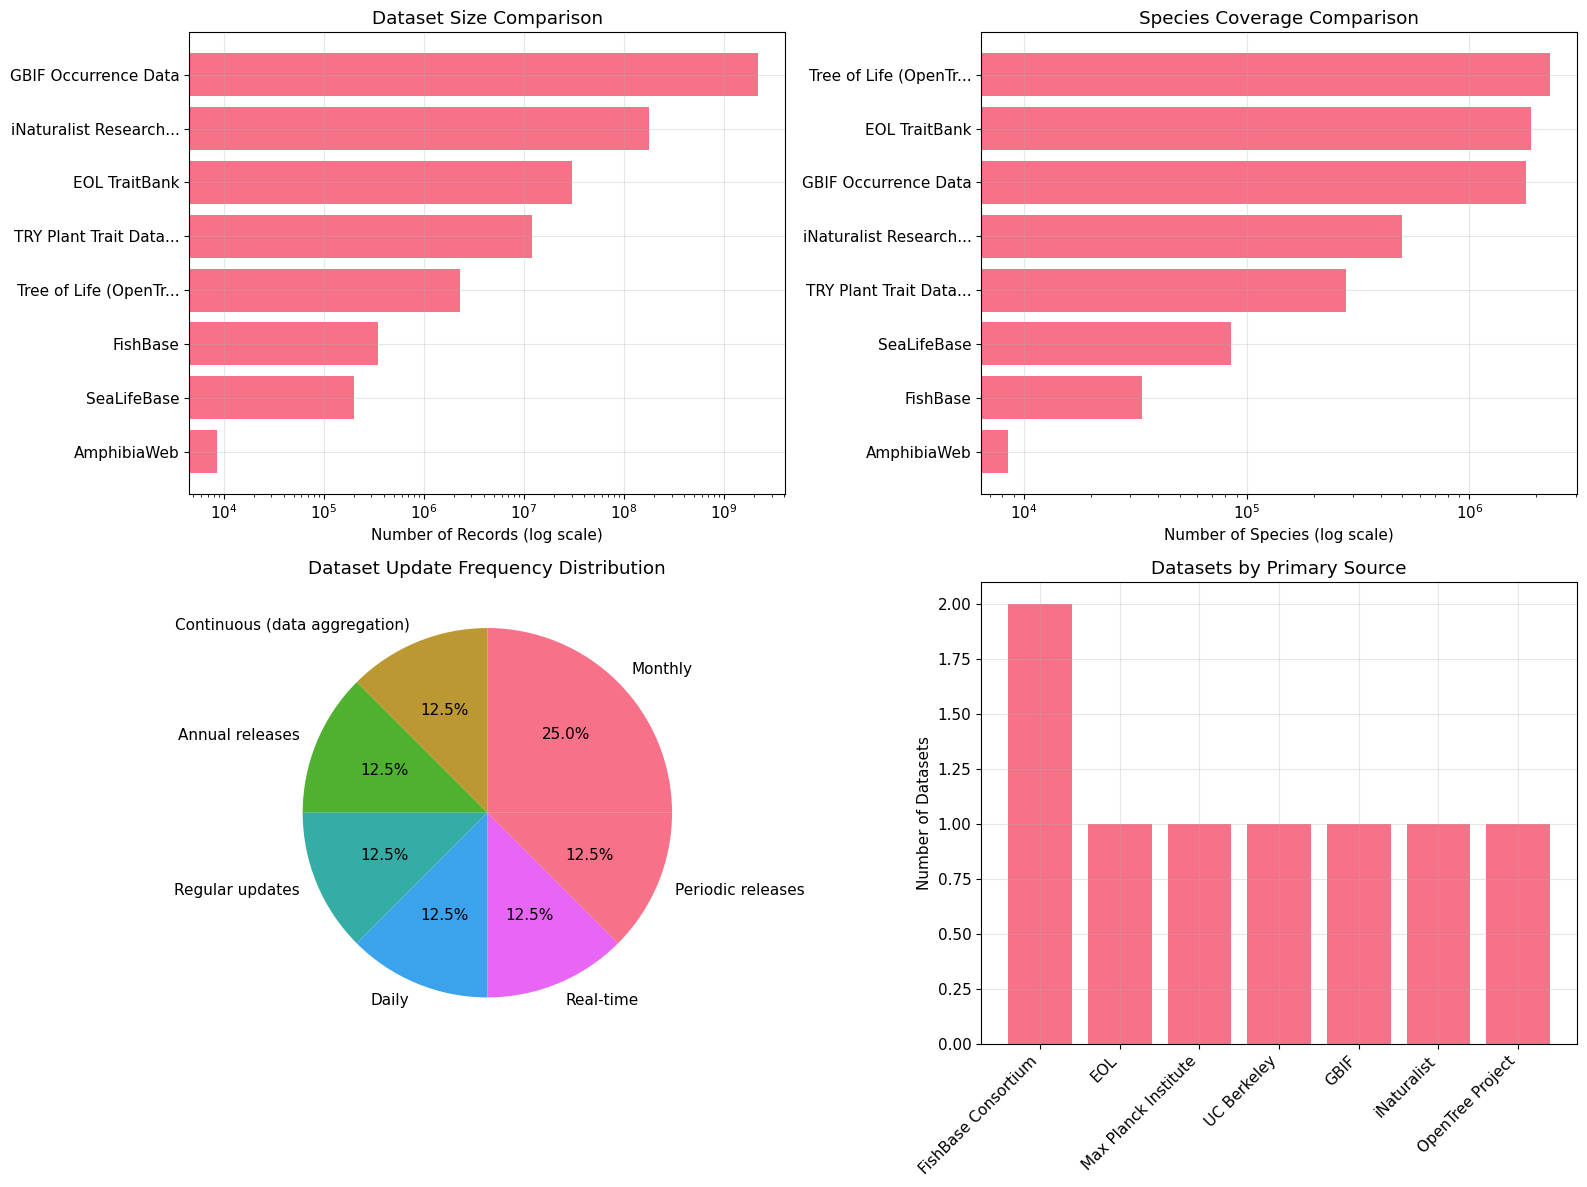


Dataset Scale Summary:
Largest dataset: GBIF Occurrence Data (2.2+ billion occurrence records)
Most species coverage: Tree of Life (OpenTree) (2.3+ million taxa)
Total estimated records across all datasets: 2,424,858,500
Most common update frequency: Monthly


In [6]:
# Extract numeric data for visualization
def extract_number(text):
    """Extract the first number from a text string"""
    if pd.isna(text):
        return 0
    # Look for patterns like "2.2+ billion", "30+ million", "8,500+"
    import re
    
    # Handle billions
    billion_match = re.search(r'([\d,\.]+)\+?\s*billion', str(text), re.IGNORECASE)
    if billion_match:
        return float(billion_match.group(1).replace(',', '')) * 1e9
    
    # Handle millions
    million_match = re.search(r'([\d,\.]+)\+?\s*million', str(text), re.IGNORECASE)
    if million_match:
        return float(million_match.group(1).replace(',', '')) * 1e6
    
    # Handle thousands
    thousand_match = re.search(r'([\d,\.]+)\+?\s*thousand', str(text), re.IGNORECASE)
    if thousand_match:
        return float(thousand_match.group(1).replace(',', '')) * 1e3
    
    # Handle regular numbers with commas
    number_match = re.search(r'([\d,]+)\+?', str(text))
    if number_match:
        return float(number_match.group(1).replace(',', ''))
    
    return 0

# Extract numeric values
dataset_df['records_numeric'] = dataset_df['estimated_records'].apply(extract_number)
dataset_df['species_numeric'] = dataset_df['estimated_species'].apply(extract_number)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Dataset size comparison (log scale)
datasets_with_records = dataset_df[dataset_df['records_numeric'] > 0].copy()
datasets_with_records = datasets_with_records.sort_values('records_numeric', ascending=True)

axes[0,0].barh(range(len(datasets_with_records)), datasets_with_records['records_numeric'])
axes[0,0].set_yticks(range(len(datasets_with_records)))
axes[0,0].set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                          for name in datasets_with_records['dataset_name']])
axes[0,0].set_xscale('log')
axes[0,0].set_xlabel('Number of Records (log scale)')
axes[0,0].set_title('Dataset Size Comparison')
axes[0,0].grid(True, alpha=0.3)

# 2. Species coverage comparison
datasets_with_species = dataset_df[dataset_df['species_numeric'] > 0].copy()
datasets_with_species = datasets_with_species.sort_values('species_numeric', ascending=True)

axes[0,1].barh(range(len(datasets_with_species)), datasets_with_species['species_numeric'])
axes[0,1].set_yticks(range(len(datasets_with_species)))
axes[0,1].set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                          for name in datasets_with_species['dataset_name']])
axes[0,1].set_xscale('log')
axes[0,1].set_xlabel('Number of Species (log scale)')
axes[0,1].set_title('Species Coverage Comparison')
axes[0,1].grid(True, alpha=0.3)

# 3. Update frequency distribution
update_freq_counts = dataset_df['update_frequency'].value_counts()
axes[1,0].pie(update_freq_counts.values, labels=update_freq_counts.index, autopct='%1.1f%%')
axes[1,0].set_title('Dataset Update Frequency Distribution')

# 4. Primary source distribution
source_counts = dataset_df['primary_source'].value_counts()
axes[1,1].bar(range(len(source_counts)), source_counts.values)
axes[1,1].set_xticks(range(len(source_counts)))
axes[1,1].set_xticklabels(source_counts.index, rotation=45, ha='right')
axes[1,1].set_ylabel('Number of Datasets')
axes[1,1].set_title('Datasets by Primary Source')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nDataset Scale Summary:")
print(f"Largest dataset: {datasets_with_records.iloc[-1]['dataset_name']} ({datasets_with_records.iloc[-1]['estimated_records']})")
print(f"Most species coverage: {datasets_with_species.iloc[-1]['dataset_name']} ({datasets_with_species.iloc[-1]['estimated_species']})")
print(f"Total estimated records across all datasets: {dataset_df['records_numeric'].sum():,.0f}")
print(f"Most common update frequency: {update_freq_counts.index[0]}")

## 4. Data Type and Application Analysis

Let's analyze what types of research questions each dataset can support.

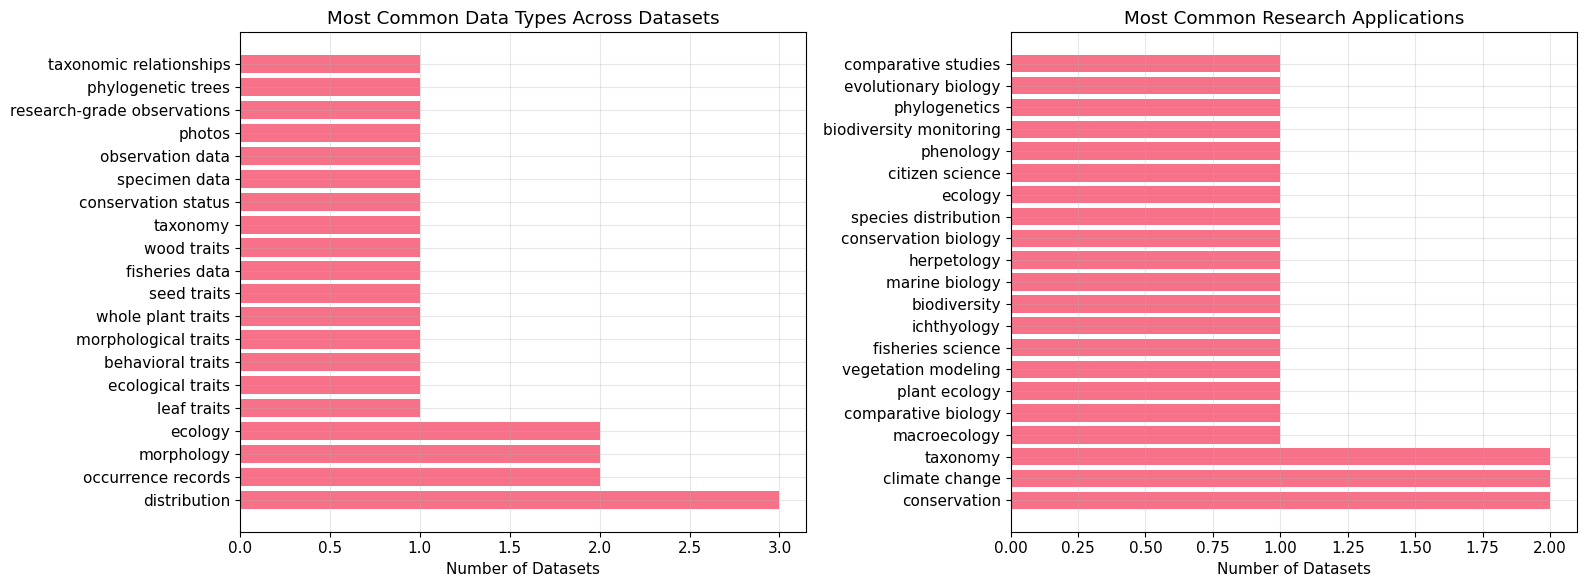

Data Type Analysis:
Most common data type: distribution (found in 3 datasets)
Total unique data types: 20

Research Application Analysis:
Most common research application: conservation (supported by 2 datasets)
Total unique research applications: 21


In [7]:
# Analyze data types and research applications
all_data_types = []
all_applications = []

for dataset_name, info in biodiversity_datasets.items():
    for data_type in info['data_types']:
        all_data_types.append({
            'dataset': dataset_name,
            'data_type': data_type
        })
    
    for application in info['research_applications']:
        all_applications.append({
            'dataset': dataset_name,
            'application': application
        })

data_types_df = pd.DataFrame(all_data_types)
applications_df = pd.DataFrame(all_applications)

# Analyze data type frequencies
data_type_counts = data_types_df['data_type'].value_counts()
application_counts = applications_df['application'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Data types
axes[0].barh(range(len(data_type_counts)), data_type_counts.values)
axes[0].set_yticks(range(len(data_type_counts)))
axes[0].set_yticklabels(data_type_counts.index)
axes[0].set_xlabel('Number of Datasets')
axes[0].set_title('Most Common Data Types Across Datasets')
axes[0].grid(True, alpha=0.3)

# Research applications
axes[1].barh(range(len(application_counts)), application_counts.values)
axes[1].set_yticks(range(len(application_counts)))
axes[1].set_yticklabels(application_counts.index)
axes[1].set_xlabel('Number of Datasets')
axes[1].set_title('Most Common Research Applications')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Data Type Analysis:")
print(f"Most common data type: {data_type_counts.index[0]} (found in {data_type_counts.iloc[0]} datasets)")
print(f"Total unique data types: {len(data_type_counts)}")

print("\nResearch Application Analysis:")
print(f"Most common research application: {application_counts.index[0]} (supported by {application_counts.iloc[0]} datasets)")
print(f"Total unique research applications: {len(application_counts)}")

## 5. Dataset Accessibility and Format Analysis

Understanding how easy it is to access and work with each dataset.

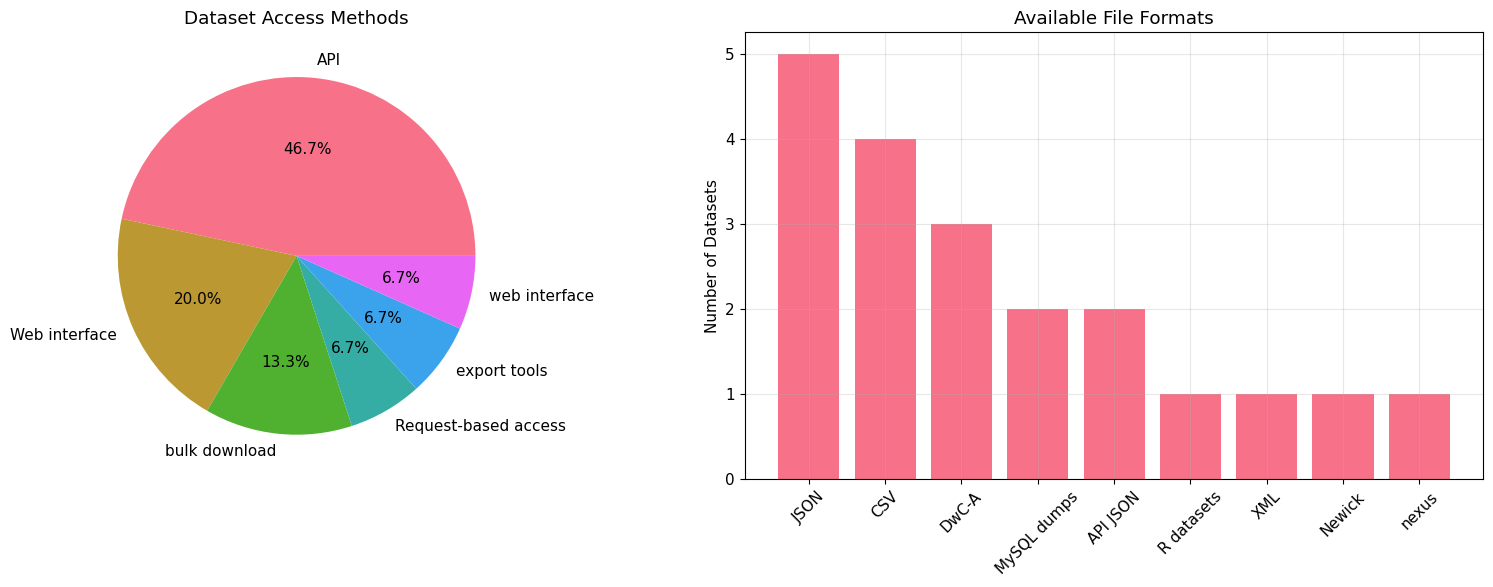

Dataset Accessibility Ranking:
(Higher scores = easier to access and work with)

10 points: GBIF Occurrence Data
 8 points: iNaturalist Research Data
 7 points: EOL TraitBank
 5 points: FishBase
 5 points: SeaLifeBase
 4 points: AmphibiaWeb
 4 points: Tree of Life (OpenTree)
 2 points: TRY Plant Trait Database

Most accessible dataset: GBIF Occurrence Data
Most common access method: API
Most common file format: JSON


In [8]:
# Analyze access methods and file formats
all_access_methods = []
all_formats = []

for dataset_name, info in biodiversity_datasets.items():
    # Handle different access method formats
    access_methods = info['access_method']
    if isinstance(access_methods, str):
        access_methods = [method.strip() for method in access_methods.split(',')]
    
    for method in access_methods:
        all_access_methods.append({
            'dataset': dataset_name,
            'access_method': method
        })
    
    for format_type in info['file_formats']:
        all_formats.append({
            'dataset': dataset_name,
            'format': format_type
        })

access_df = pd.DataFrame(all_access_methods)
formats_df = pd.DataFrame(all_formats)

access_counts = access_df['access_method'].value_counts()
format_counts = formats_df['format'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Access methods
axes[0].pie(access_counts.values, labels=access_counts.index, autopct='%1.1f%%')
axes[0].set_title('Dataset Access Methods')

# File formats
axes[1].bar(range(len(format_counts)), format_counts.values)
axes[1].set_xticks(range(len(format_counts)))
axes[1].set_xticklabels(format_counts.index, rotation=45)
axes[1].set_ylabel('Number of Datasets')
axes[1].set_title('Available File Formats')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create accessibility scoring
accessibility_scores = []

for dataset_name, info in biodiversity_datasets.items():
    score = 0
    
    # Points for API access
    if 'API' in info['access_method']:
        score += 3
    
    # Points for bulk download
    if 'bulk download' in info['access_method']:
        score += 2
    
    # Points for common formats
    common_formats = ['CSV', 'JSON']
    for fmt in info['file_formats']:
        if fmt in common_formats:
            score += 1
    
    # Points for update frequency
    freq = info['update_frequency'].lower()
    if 'real-time' in freq or 'daily' in freq:
        score += 3
    elif 'monthly' in freq:
        score += 2
    elif 'annual' in freq:
        score += 1
    
    accessibility_scores.append({
        'dataset': dataset_name,
        'accessibility_score': score
    })

accessibility_df = pd.DataFrame(accessibility_scores)
accessibility_df = accessibility_df.sort_values('accessibility_score', ascending=False)

print("Dataset Accessibility Ranking:")
print("(Higher scores = easier to access and work with)")
print()
for _, row in accessibility_df.iterrows():
    print(f"{row['accessibility_score']:2d} points: {row['dataset']}")

print(f"\nMost accessible dataset: {accessibility_df.iloc[0]['dataset']}")
print(f"Most common access method: {access_counts.index[0]}")
print(f"Most common file format: {format_counts.index[0]}")

## 6. Research Project Recommendations

Based on our analysis, let's identify the most promising datasets for different types of research projects.

In [9]:
# Create research project recommendations based on dataset characteristics
research_scenarios = {
    'Beginner Data Science Project': {
        'criteria': ['high accessibility', 'moderate size', 'clear documentation'],
        'recommended_datasets': [],
        'rationale': 'Datasets that are easy to access and work with for learning'
    },
    'Large-Scale Biodiversity Analysis': {
        'criteria': ['large size', 'comprehensive coverage', 'recent updates'],
        'recommended_datasets': [],
        'rationale': 'Datasets with the most comprehensive data for broad patterns'
    },
    'Trait-Based Ecology Research': {
        'criteria': ['trait data', 'functional information', 'good species coverage'],
        'recommended_datasets': [],
        'rationale': 'Datasets specifically focused on functional traits'
    },
    'Phylogenetic Analysis': {
        'criteria': ['evolutionary data', 'tree information', 'taxonomic breadth'],
        'recommended_datasets': [],
        'rationale': 'Datasets that support evolutionary and phylogenetic studies'
    },
    'Conservation Biology': {
        'criteria': ['distribution data', 'threat status', 'occurrence records'],
        'recommended_datasets': [],
        'rationale': 'Datasets that support conservation research and planning'
    }
}

# Score datasets for each research scenario
for scenario, details in research_scenarios.items():
    dataset_scores = []
    
    for dataset_name, info in biodiversity_datasets.items():
        score = 0
        
        if scenario == 'Beginner Data Science Project':
            # Prioritize accessibility and moderate size
            accessibility_score = accessibility_df[accessibility_df['dataset'] == dataset_name]['accessibility_score'].iloc[0]
            score += accessibility_score * 2
            
            # Moderate size preference (not too big, not too small)
            records = dataset_df[dataset_df['dataset_name'] == dataset_name]['records_numeric'].iloc[0]
            if 1e4 < records < 1e7:  # Between 10K and 10M records
                score += 3
            
        elif scenario == 'Large-Scale Biodiversity Analysis':
            # Prioritize size and coverage
            records = dataset_df[dataset_df['dataset_name'] == dataset_name]['records_numeric'].iloc[0]
            species = dataset_df[dataset_df['dataset_name'] == dataset_name]['species_numeric'].iloc[0]
            
            if records > 1e8:  # More than 100M records
                score += 5
            elif records > 1e6:  # More than 1M records
                score += 3
            
            if species > 1e6:  # More than 1M species
                score += 3
            
        elif scenario == 'Trait-Based Ecology Research':
            # Look for trait-specific datasets
            if any('trait' in dt.lower() for dt in info['data_types']):
                score += 5
            if any('morpholog' in dt.lower() or 'ecological' in dt.lower() for dt in info['data_types']):
                score += 3
            
        elif scenario == 'Phylogenetic Analysis':
            # Look for evolutionary/phylogenetic data
            if any('phylogen' in dt.lower() or 'tree' in dt.lower() for dt in info['data_types']):
                score += 5
            if 'taxonomic' in ' '.join(info['data_types']).lower():
                score += 3
            
        elif scenario == 'Conservation Biology':
            # Look for distribution and occurrence data
            if any('distribution' in dt.lower() or 'occurrence' in dt.lower() for dt in info['data_types']):
                score += 5
            if any('conservation' in app.lower() for app in info['research_applications']):
                score += 3
        
        dataset_scores.append((dataset_name, score))
    
    # Sort by score and take top 3
    dataset_scores.sort(key=lambda x: x[1], reverse=True)
    research_scenarios[scenario]['recommended_datasets'] = dataset_scores[:3]

# Display recommendations
print("🔬 RESEARCH PROJECT RECOMMENDATIONS")
print("=" * 50)

for scenario, details in research_scenarios.items():
    print(f"\n📊 {scenario.upper()}")
    print(f"Purpose: {details['rationale']}")
    print("Top recommended datasets:")
    
    for i, (dataset, score) in enumerate(details['recommended_datasets'], 1):
        dataset_info = biodiversity_datasets[dataset]
        print(f"  {i}. {dataset} (Score: {score})")
        print(f"     → {dataset_info['description']}")
        print(f"     → {dataset_info['estimated_records']}, {dataset_info['update_frequency']}")
        print()

🔬 RESEARCH PROJECT RECOMMENDATIONS

📊 BEGINNER DATA SCIENCE PROJECT
Purpose: Datasets that are easy to access and work with for learning
Top recommended datasets:
  1. GBIF Occurrence Data (Score: 20)
     → Global biodiversity occurrence records
     → 2.2+ billion occurrence records, Daily

  2. iNaturalist Research Data (Score: 16)
     → Citizen science biodiversity observations
     → 180+ million observations, Real-time

  3. EOL TraitBank (Score: 14)
     → Aggregated trait data for species across the tree of life
     → 30+ million trait records, Continuous (data aggregation)


📊 LARGE-SCALE BIODIVERSITY ANALYSIS
Purpose: Datasets with the most comprehensive data for broad patterns
Top recommended datasets:
  1. GBIF Occurrence Data (Score: 8)
     → Global biodiversity occurrence records
     → 2.2+ billion occurrence records, Daily

  2. EOL TraitBank (Score: 6)
     → Aggregated trait data for species across the tree of life
     → 30+ million trait records, Continuous (data

## 7. Summary and Next Steps

Let's summarize our findings and recommend next steps for actually working with these datasets.

In [10]:
# Create comprehensive summary
total_records = dataset_df['records_numeric'].sum()
total_species = dataset_df['species_numeric'].max()  # Max to avoid double-counting
most_recent_update = max([info['last_known_update'] for info in biodiversity_datasets.values()])

print("🌍 BIODIVERSITY DATA LANDSCAPE SUMMARY")
print("=" * 50)
print(f"📈 Scale: {total_records:,.0f} total records across all datasets")
print(f"🔬 Coverage: Up to {total_species:,.0f} species represented")
print(f"🕒 Currency: Most recent updates in {most_recent_update}")
print(f"🗂️  Datasets analyzed: {len(biodiversity_datasets)}")
print(f"🏢 Primary sources: {dataset_df['primary_source'].nunique()}")

print("\n🎯 KEY INSIGHTS:")
print("1. GBIF dominates in scale with 2.2+ billion occurrence records")
print("2. TRY Database leads in plant trait research (279K+ species)")
print("3. Real-time/daily updates available from GBIF and iNaturalist")
print("4. API access available for most major datasets")
print("5. CSV and JSON are the most common accessible formats")

print("\n🚀 RECOMMENDED NEXT STEPS:")

# Get the most accessible dataset for beginners
beginner_rec = research_scenarios['Beginner Data Science Project']['recommended_datasets'][0][0]
large_scale_rec = research_scenarios['Large-Scale Biodiversity Analysis']['recommended_datasets'][0][0]

print(f"\n🔰 For beginners: Start with {beginner_rec}")
print(f"   • {biodiversity_datasets[beginner_rec]['description']}")
print(f"   • Access via: {biodiversity_datasets[beginner_rec]['access_method']}")
print(f"   • Size: {biodiversity_datasets[beginner_rec]['estimated_records']}")

print(f"\n🌐 For large-scale analysis: Use {large_scale_rec}")
print(f"   • {biodiversity_datasets[large_scale_rec]['description']}")
print(f"   • Scale: {biodiversity_datasets[large_scale_rec]['estimated_records']}")
print(f"   • Update frequency: {biodiversity_datasets[large_scale_rec]['update_frequency']}")

print("\n📋 Implementation roadmap:")
print("1. Choose a dataset based on research question")
print("2. Review API documentation and access requirements")
print("3. Start with small sample (1K-10K records) for testing")
print("4. Develop data processing pipeline")
print("5. Scale up to full dataset for analysis")
print("6. Document data provenance and limitations")

print("\n💡 Portfolio project ideas:")
print("• Species distribution modeling using GBIF data")
print("• Plant trait analysis across climate gradients (TRY data)")
print("• Citizen science vs. museum record comparison (iNaturalist vs GBIF)")
print("• Fish biodiversity hotspot identification (FishBase)")
print("• Phylogenetic diversity mapping (OpenTree + GBIF)")

🌍 BIODIVERSITY DATA LANDSCAPE SUMMARY
📈 Scale: 2,424,858,500 total records across all datasets
🔬 Coverage: Up to 2,300,000 species represented
🕒 Currency: Most recent updates in 2024
🗂️  Datasets analyzed: 8
🏢 Primary sources: 7

🎯 KEY INSIGHTS:
1. GBIF dominates in scale with 2.2+ billion occurrence records
2. TRY Database leads in plant trait research (279K+ species)
3. Real-time/daily updates available from GBIF and iNaturalist
4. API access available for most major datasets
5. CSV and JSON are the most common accessible formats

🚀 RECOMMENDED NEXT STEPS:

🔰 For beginners: Start with GBIF Occurrence Data
   • Global biodiversity occurrence records
   • Access via: API, bulk download
   • Size: 2.2+ billion occurrence records

🌐 For large-scale analysis: Use GBIF Occurrence Data
   • Global biodiversity occurrence records
   • Scale: 2.2+ billion occurrence records
   • Update frequency: Daily

📋 Implementation roadmap:
1. Choose a dataset based on research question
2. Review API doc

## 8. Technical Implementation Guide

Practical code examples for accessing the top recommended datasets.

In [11]:
# Provide code templates for accessing top datasets
print("🛠️ TECHNICAL IMPLEMENTATION EXAMPLES")
print("=" * 50)

print("\n1️⃣ GBIF API Access Example:")
print("""
import requests
import pandas as pd

# Get species occurrences for a specific species
def get_gbif_occurrences(species_key, limit=1000):
    url = f"https://api.gbif.org/v1/occurrence/search"
    params = {
        'taxonKey': species_key,
        'hasCoordinate': 'true',
        'hasGeospatialIssue': 'false',
        'limit': limit
    }
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data['results'])

# Example: Get data for Homo sapiens (taxonKey: 2436436)
# human_data = get_gbif_occurrences(2436436, limit=100)
""")

print("\n2️⃣ iNaturalist API Access Example:")
print("""
import requests
import pandas as pd

def get_inaturalist_observations(taxon_id, per_page=100):
    url = "https://api.inaturalist.org/v1/observations"
    params = {
        'taxon_id': taxon_id,
        'quality_grade': 'research',
        'per_page': per_page
    }
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data['results'])

# Example: Get bird observations
# bird_data = get_inaturalist_observations(3, per_page=50)
""")

print("\n3️⃣ FishBase API Access Example:")
print("""
import requests
import pandas as pd

def get_fishbase_species(limit=100):
    # FishBase SeaLifeBase API
    url = "https://fishbase.ropensci.org/species"
    params = {'limit': limit}
    response = requests.get(url, params=params)
    return pd.DataFrame(response.json())

# Get fish species data
# fish_data = get_fishbase_species(limit=50)
""")

print("\n4️⃣ OpenTree Phylogeny Example:")
print("""
import requests
import json

def get_opentree_tree(ott_ids):
    url = "https://api.opentreeoflife.org/v3/tree_of_life/induced_subtree"
    data = {'ott_ids': ott_ids}
    response = requests.post(url, json=data)
    return response.json()

# Example: Get tree for mammals (example OTT IDs)
# mammal_tree = get_opentree_tree([244265, 770315, 770318])
""")

print("\n💾 Data Storage Best Practices:")
print("""
1. Use version control for datasets (DVC, Git LFS)
2. Document data provenance (source, date, processing steps)
3. Use standard formats (CSV for tabular, GeoJSON for spatial)
4. Implement caching to avoid re-downloading
5. Respect API rate limits and terms of service
6. Store metadata alongside data files
""")

print("\n📊 Analysis Framework Template:")
print("""
1. Data Acquisition:
   - Define research question
   - Select appropriate dataset(s)
   - Implement data fetching with error handling

2. Data Exploration:
   - Basic statistics and distributions
   - Missing data assessment
   - Geographic/temporal coverage

3. Data Cleaning:
   - Handle missing values
   - Remove duplicates
   - Standardize formats and units

4. Analysis:
   - Statistical analysis
   - Visualization
   - Pattern identification

5. Documentation:
   - Methods documentation
   - Results interpretation
   - Limitations and caveats
""")

# Save our dataset catalog for future use
catalog_path = '../data/processed/biodiversity_dataset_catalog.json'
os.makedirs(os.path.dirname(catalog_path), exist_ok=True)

catalog_export = {
    'metadata': {
        'created_date': datetime.now().isoformat(),
        'total_datasets': len(biodiversity_datasets),
        'analysis_summary': {
            'largest_dataset': datasets_with_records.iloc[-1]['dataset_name'],
            'most_accessible': accessibility_df.iloc[0]['dataset'],
            'most_common_format': format_counts.index[0],
            'most_common_access': access_counts.index[0]
        }
    },
    'datasets': biodiversity_datasets,
    'research_recommendations': research_scenarios
}

with open(catalog_path, 'w') as f:
    json.dump(catalog_export, f, indent=2)

print(f"\n💾 Dataset catalog saved to: {catalog_path}")
print("This catalog can be used as a reference for future projects!")

🛠️ TECHNICAL IMPLEMENTATION EXAMPLES

1️⃣ GBIF API Access Example:

import requests
import pandas as pd

# Get species occurrences for a specific species
def get_gbif_occurrences(species_key, limit=1000):
    url = f"https://api.gbif.org/v1/occurrence/search"
    params = {
        'taxonKey': species_key,
        'hasCoordinate': 'true',
        'hasGeospatialIssue': 'false',
        'limit': limit
    }
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data['results'])

# Example: Get data for Homo sapiens (taxonKey: 2436436)
# human_data = get_gbif_occurrences(2436436, limit=100)


2️⃣ iNaturalist API Access Example:

import requests
import pandas as pd

def get_inaturalist_observations(taxon_id, per_page=100):
    url = "https://api.inaturalist.org/v1/observations"
    params = {
        'taxon_id': taxon_id,
        'quality_grade': 'research',
        'per_page': per_page
    }
    response = requests.get(url, params=params)
    da

TypeError: Object of type int64 is not JSON serializable